In [1]:
from andi_datasets.models_phenom import models_phenom
from andi_datasets.analysis import *

from helpersMSD import *
from helpersGeneration import *
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# number of time steps per trajectory (frames)
T = 500
# number of trajectories
N = 500
# Length of box (pixels), set to 0 to make them start at 0,0
L = 0 
# diffusion coefficient (pixels^2 / frame)
D = 0.2

In [7]:
trajs, labels = models_phenom().single_state(N, 
                                L = L,
                                T = T,
                                Ds = [D, 0.01], # Mean and variance
                                alphas = 1)
print(trajs.shape,labels.shape)
# Need to reshape generated trajectories because they are in format (T,N,dim), but we want them in (N,T,dim)
trajs = trajs.transpose(1,0,2)
labels = labels.transpose(1,0,2)
# Labels are now in format (N,T,3): for each particle T times the tuple (alpha, D, state)
print(f"Particle 0 [alpha, Gen_D, state]: {labels[0,0,:]}")
print(f"Particle 1 [alpha, Gen_D, state]: {labels[1,0,:]}")

(500, 500, 2) (500, 500, 3)
Particle 0 [alpha, Gen_D, state]: [1.         0.28026697 2.        ]
Particle 1 [alpha, Gen_D, state]: [1.         0.01650595 2.        ]


In [4]:
# First Trajectory:
traj1 = trajs[0,:,:]
print(f"Trajectory 1 shape: (T,dim=2): {traj1.shape}, Labels shape: {labels[0,:,:].shape}")

Trajectory 1 shape: (T,dim=2): (500, 2), Labels shape: (500, 3)


Estimated Diffusion Coefficient: 0.20851293905225657


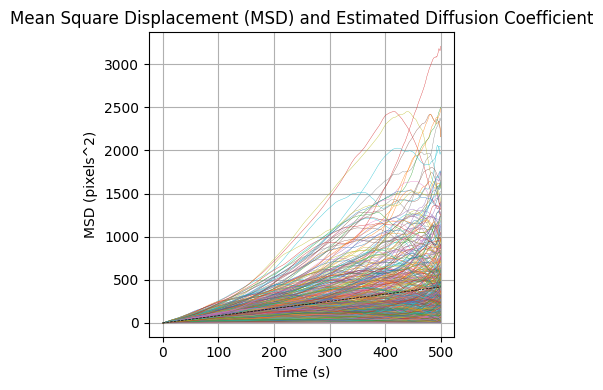

0.20851293905225657

In [5]:
# Estimation of diffusion coefficient done using MSD
# For each trajectory the MSD is computed according to this formula: 
# https://en.wikipedia.org/wiki/Mean_squared_displacement#Definition_of_MSD_for_time_lags
# The diffusion coefficient is then predicted using a the slope of a linear model without intercept
msds = mean_square_displacements(trajs)
computeAndPlotMeanMSD(msds,N,T,1,1)

In [ ]:

N=100
T=100
trajs, labels = models_phenom().single_state(N=N, 
                                L = L,
                                T = T,
                                Ds = [0.5, 0.01], # Mean and variance
                                alphas = 1)
print(trajs.shape,labels.shape)
# Need to reshape generated trajectories because they are in format (T,N,dim), but we want them in (N,T,dim)
trajs = trajs.transpose(1,0,2)
labels = labels.transpose(1,0,2)

# Andi analysis estimates a different diffusion coefficient, which is not consistent with ours
t_lags = np.arange(T) * 1   # Time points for MSD plot

# Here is the method used by us: 
msds = mean_square_displacements(trajs)

D_s = estimateDfromMSDs(msds,t_lags)

D_s_2 = estimateDfromMSDs2(msds,t_lags)



D_s2 = msd_analysis().get_diff_coeff(trajs)

print(np.mean(D_s), np.mean(D_s_2),np.mean(D_s2))
print(np.min(D_s), np.min(D_s2))

(100, 100, 2) (100, 100, 3)
0.5737520691591085 0.5830536071799731 0.5336371694674183
0.05345238106345288 0.1674074388178533


Estimated Diffusion Coefficient: 0.25094138530265603


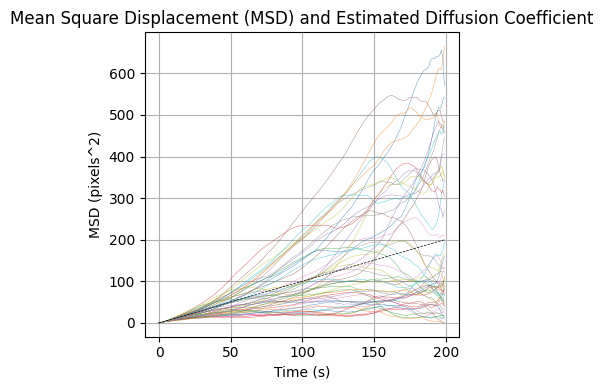

Estimated Diffusion Coefficient: 0.18770768788293338


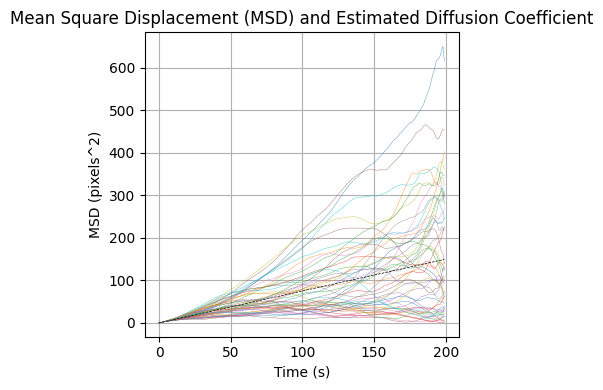

Mean: 0.25094138530265603
Mean: 0.18770768788293343


In [7]:
# number of time steps per trajectory (frames)
T = 200
# number of trajectories/particles
N = 50
# Length of box (pixels)
L = 0
# diffusion coefficient (pixels^2 / frame)
D = 0.2
def meanD():
    trajs, labels = models_phenom().single_state(N, 
                                    L = L,
                                    T = T,
                                    Ds = [D, 0.0], # Mean and variance
                                    alphas = 1)
    
    #trajsReshaped = trajs.reshape(N,T,2)
    trajsTrans = trajs.transpose(1,0,2)
    #trajsSwap = trajs.swapaxes(0,1)

    trajs2 = brownian_motion(N,T,1,D,1,True)
    #print(trajs.shape, trajs2.shape,trajs2.reshape(T,N,2).shape)

    msds = mean_square_displacements(trajsTrans)
    msds2 = mean_square_displacements(trajs2)

    computeAndPlotMeanMSD(msds,N,T,1,1)
    computeAndPlotMeanMSD(msds2,N,T,1,1)

    #print(msds.shape, msds2.shape)



    time_range = np.arange(T) * 1   # Time points for MSD plot
    Ds = []
    Ds2 = []

    for i in range(N):
        Ds.append(estimateDfromMSD(msds[i,:],time_range))
        Ds2.append(estimateDfromMSD(msds2[i,:],time_range))

    return np.mean(np.array(Ds)), np.mean(np.array(Ds2))

meanDs = []
meanDs2 = []

for j in range(1):
    d1, d2 = meanD()
    meanDs.append(d1)
    meanDs2.append(d2)

print("Mean:",np.mean(np.array(meanDs)))
print("Mean:",np.mean(np.array(meanDs2)))



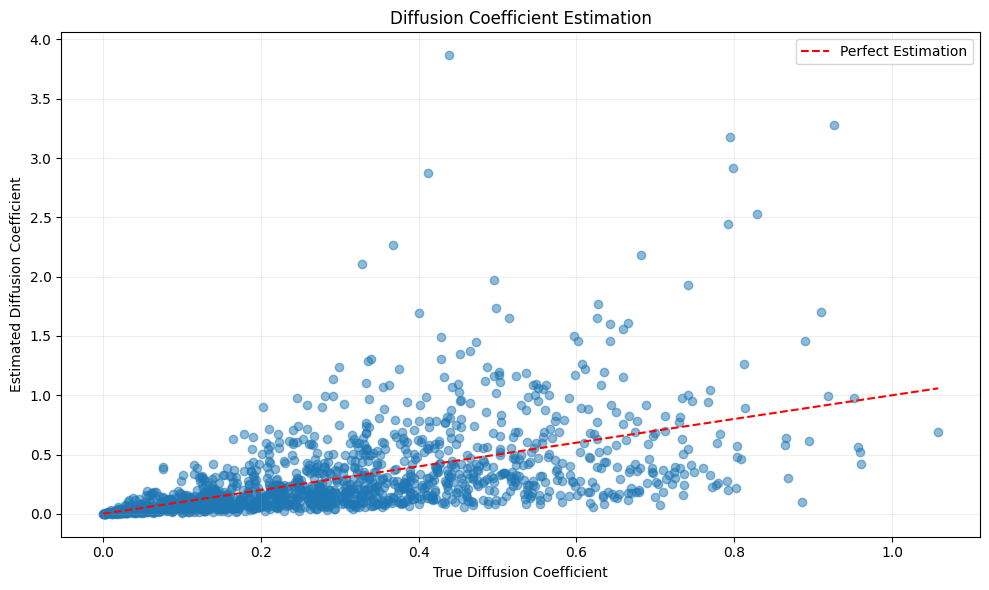

In [11]:
import matplotlib.pyplot as plt
def plot_diffusion_coefficient_estimation():
    # Parameters
    D_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    N = 200  # Number of particles
    T = 100  # Number of time steps
    time_range = np.arange(T)

    # Prepare plot
    plt.figure(figsize=(10, 6))
    
    # Store results for plotting
    true_Ds = []
    estimated_Ds = []

    # Iterate through D values
    for D in D_values:
        # Generate trajectories
        trajs, labels= models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0.05], alphas=1)
        
        # Transpose trajectories
        trajsTrans = trajs.transpose(1, 0, 2)
        
        # Calculate Mean Square Displacements
        msds = mean_square_displacements(trajsTrans)
        
        # Estimate D for each particle
        Ds = [estimateDfromMSD(msds[i, :], time_range) for i in range(N)]
        
        # Plot results
        true_Ds.extend([labels[0,i,1] for i in range(N)])
        estimated_Ds.extend(Ds)

    # Scatter plot
    plt.scatter(true_Ds, estimated_Ds, alpha=0.5)
    plt.plot([min(true_Ds), max(true_Ds)], [min(true_Ds), max(true_Ds)], 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Diffusion Coefficient Estimation')

    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Run the analysis
plot_diffusion_coefficient_estimation()

40.0


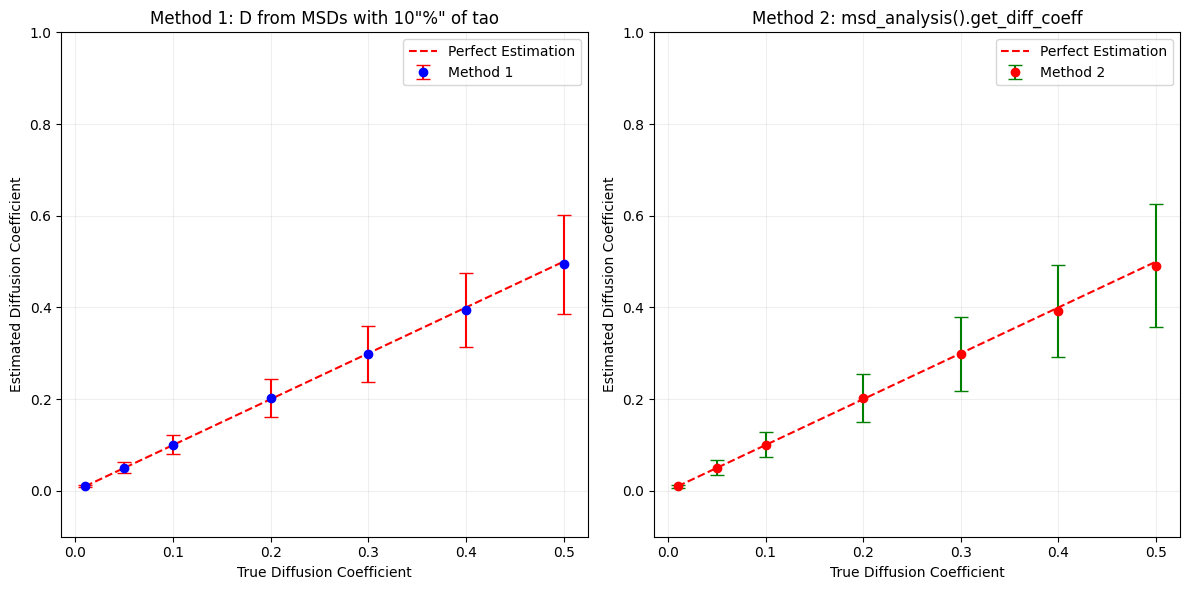

In [ ]:

def plot_diffusion_coefficient_estimation_comparison():
    """
    Compare two methods of estimating diffusion coefficients:
    1. Estimating from Mean Square Displacements
    2. Using an alternative method (msd_analysis().get_diff_coeff)
    """
    # Parameters
    D_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    N = 200  # Number of particles
    T = 400  # Number of time steps
    
    t_lag_factor = 0.1
    print(T*t_lag_factor)

    time_range = np.arange(T * t_lag_factor)

    # Prepare plot
    plt.figure(figsize=(12, 6))
    
    # Lists to store results for error bar calculation
    true_Ds_means = []
    estimated_Ds_method1_means = []
    estimated_Ds_method1_stds = []
    estimated_Ds_method2_means = []
    estimated_Ds_method2_stds = []

    # Iterate through D values
    for D in D_values:
        # Generate trajectories
        trajs, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0.0], alphas=1)
        
        # Transpose trajectories
        trajsTrans = trajs.transpose(1, 0, 2)
        
        # Calculate Mean Square Displacements
        msds = mean_square_displacements(trajsTrans)
        
        # Method 1: Estimate D from MSDs
        Ds_method1 = estimateDfromMSDs(msds[:,:int(T*t_lag_factor)], time_range)

        # Method 2: Alternative method
        #Ds_method2 = msds[:,1] / 4
        #Ds_method2 = estimateDfromMSDs(msds[:,:int(T*t_lag_factor)], time_range)
        Ds_method2 = msd_analysis().get_diff_coeff(trajsTrans)

        # Store results for error bar calculation
        true_Ds_means.append(D)
        
        # Method 1 statistics
        estimated_Ds_method1_means.append(np.mean(Ds_method1))
        estimated_Ds_method1_stds.append(np.std(Ds_method1))
        
        # Method 2 statistics
        estimated_Ds_method2_means.append(np.mean(Ds_method2))
        estimated_Ds_method2_stds.append(np.std(Ds_method2))

    # Subplot for each method
    plt.subplot(1, 2, 1)
    # Method 1 Error bar plot
    plt.errorbar(true_Ds_means, estimated_Ds_method1_means, 
                 yerr=estimated_Ds_method1_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='red', 
                 markerfacecolor='blue', 
                 markeredgecolor='blue',
                 label='Method 1')
    
    # Perfect estimation line for Method 1
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 1: D from MSDs with 10"%" of tau')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Method 2 subplot
    plt.subplot(1, 2, 2)
    plt.errorbar(true_Ds_means, estimated_Ds_method2_means, 
                 yerr=estimated_Ds_method2_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='green', 
                 markerfacecolor='red', 
                 markeredgecolor='red',
                 label='Method 2')
    
    # Perfect estimation line for Method 2
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 2: msd_analysis().get_diff_coeff')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
plot_diffusion_coefficient_estimation_comparison()

40.0


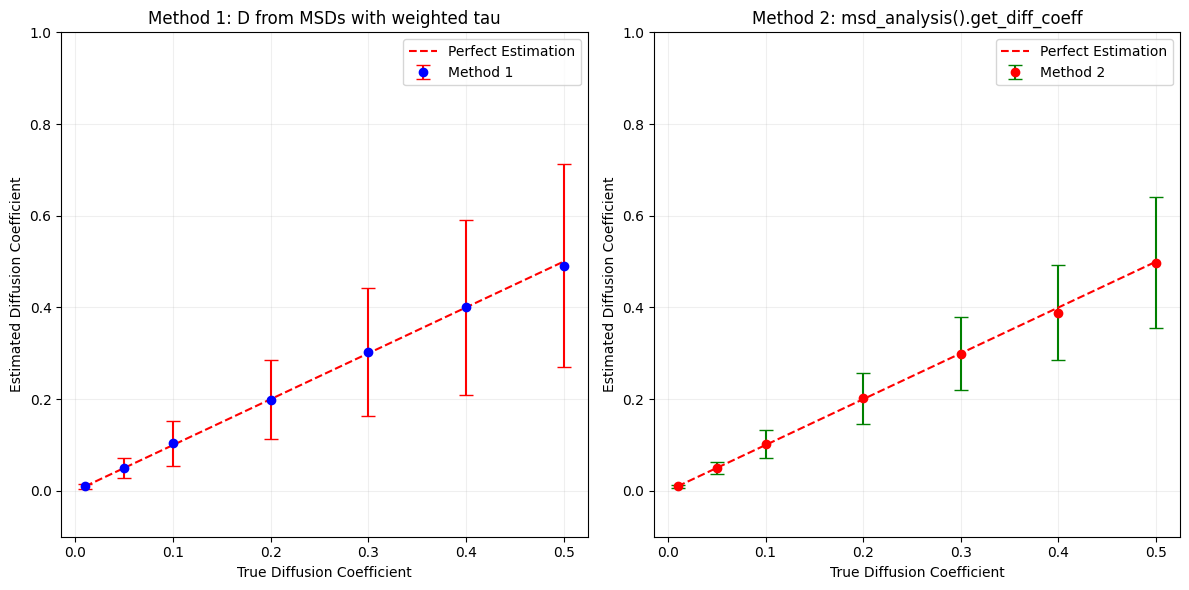

In [22]:
import matplotlib.pyplot as plt
def plot_diffusion_coefficient_estimation_comparison():
    """
    Compare two methods of estimating diffusion coefficients:
    1. Estimating from Mean Square Displacements
    2. Using an alternative method (msd_analysis().get_diff_coeff)
    """
    # Parameters
    D_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    N = 200  # Number of particles
    T = 400  # Number of time steps
    
    t_lag_factor = 0.1
    print(T*t_lag_factor)

    time_range = np.arange(T * t_lag_factor)

    # Prepare plot
    plt.figure(figsize=(12, 6))
    
    # Lists to store results for error bar calculation
    true_Ds_means = []
    estimated_Ds_method1_means = []
    estimated_Ds_method1_stds = []
    estimated_Ds_method2_means = []
    estimated_Ds_method2_stds = []

    # Iterate through D values
    for D in D_values:
        # Generate trajectories
        trajs, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0.0], alphas=1)
        
        # Transpose trajectories
        trajsTrans = trajs.transpose(1, 0, 2)
        
        # Calculate Mean Square Displacements
        msds = mean_square_displacements(trajsTrans)
        
        
        
        # Method 1: Estimate D from MSDs
        Ds_method1 = estimateDfromMSDsWeighted(msds, time_range)

        # Method 2: Alternative method
        #Ds_method2 = msds[:,1] / 4
        #Ds_method2 = estimateDfromMSDs(msds[:,:int(T*t_lag_factor)], time_range)
        Ds_method2 = msd_analysis().get_diff_coeff(trajsTrans)

        # Store results for error bar calculation
        true_Ds_means.append(D)
        
        # Method 1 statistics
        estimated_Ds_method1_means.append(np.mean(Ds_method1))
        estimated_Ds_method1_stds.append(np.std(Ds_method1))
        
        # Method 2 statistics
        estimated_Ds_method2_means.append(np.mean(Ds_method2))
        estimated_Ds_method2_stds.append(np.std(Ds_method2))

    # Subplot for each method
    plt.subplot(1, 2, 1)
    # Method 1 Error bar plot
    plt.errorbar(true_Ds_means, estimated_Ds_method1_means, 
                 yerr=estimated_Ds_method1_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='red', 
                 markerfacecolor='blue', 
                 markeredgecolor='blue',
                 label='Method 1')
    
    # Perfect estimation line for Method 1
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 1: D from MSDs with weighted tau')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Method 2 subplot
    plt.subplot(1, 2, 2)
    plt.errorbar(true_Ds_means, estimated_Ds_method2_means, 
                 yerr=estimated_Ds_method2_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='green', 
                 markerfacecolor='red', 
                 markeredgecolor='red',
                 label='Method 2')
    
    # Perfect estimation line for Method 2
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 2: msd_analysis().get_diff_coeff')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
plot_diffusion_coefficient_estimation_comparison()

<Figure size 1200x600 with 0 Axes>

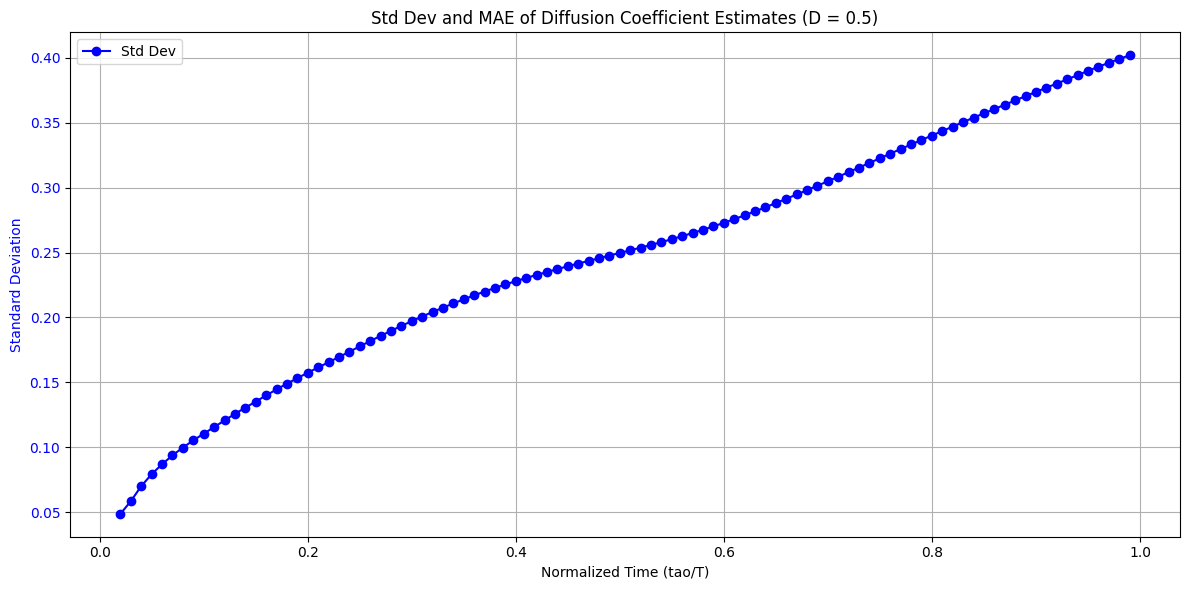

In [ ]:
def plot_error_comparison():
    """
    Compare standard deviation and mean absolute error of diffusion coefficient estimates 
    as a function of normalized time.
    """
    # Parameters
    D = 0.5
    N = 100  # Number of particles
    T = 100  # Number of time steps
    
    # Prepare plot
    plt.figure(figsize=(12, 6))
    
    # Generate trajectories
    trajs, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0.0], alphas=1)
    
    # Transpose trajectories
    trajsTrans = trajs.transpose(1, 0, 2)
    
    # Calculate Mean Square Displacements
    msds = mean_square_displacements(trajsTrans)
    
    # Lists to store results
    stdvs = []
    maes = []
    normalized_tau = []

    # Compute standard deviation and MAE for different time windows
    for tau in range(2, T):
        # Method: Estimate D from MSDs for current time window
        time_range = np.arange(tau)
        Ds_method = estimateDfromMSDs(msds[:,:tau], time_range)

        # Compute standard deviation of estimates
        current_stdv = np.std(Ds_method)
        stdvs.append(current_stdv)
        
        # Compute Mean Absolute Error
        mae = np.mean(np.abs(Ds_method-0.5))
        maes.append(mae)
        
        # Normalize tau by T
        normalized_tau.append(tau / T)
        
        #print(f"tau: {tau}, Normalized tau: {tau/T:.2f}, Std Dev: {current_stdv}, MAE: {mae}")

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot Standard Deviation
    color1 = 'blue'
    ax1.set_xlabel('Normalized Time (tau/T)')
    ax1.set_ylabel('Standard Deviation', color=color1)
    ax1.plot(normalized_tau, stdvs, 'o-', color=color1, label='Std Dev')
    ax1.tick_params(axis='y', labelcolor=color1)


    # Title and layout
    plt.title(f'Std Dev and MAE of Diffusion Coefficient Estimates (D = {D})')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(lines1 , labels1 , loc='upper left')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run the comparison
plot_error_comparison()

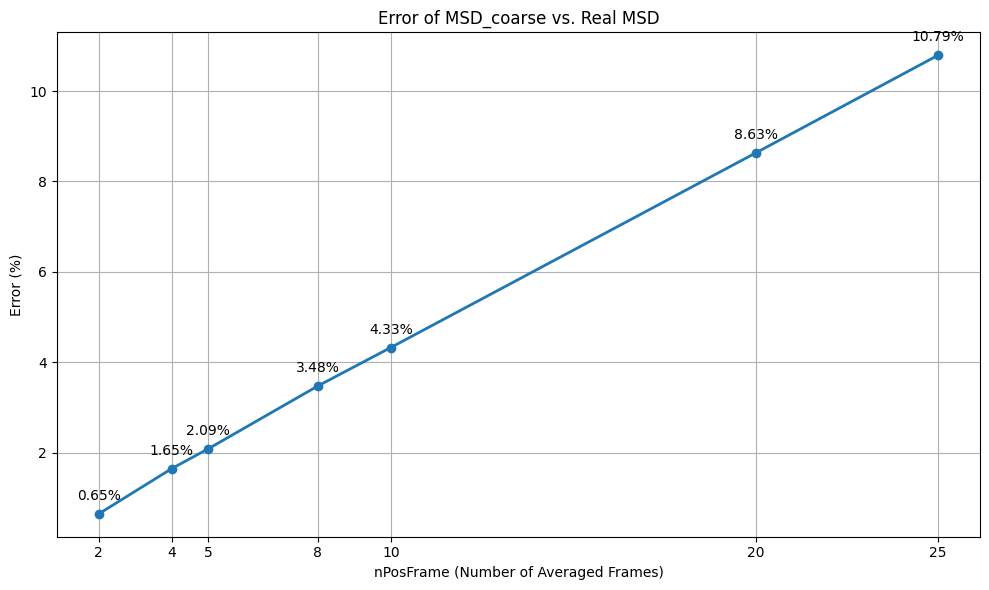

In [ ]:
# Comparison of Coarse D and real D, 
def plot_error_vs_nposframe():
    """
    Plot error percentage between normal D computation and 
    computation using averaged positions for different values of nPosFrame.
    """
    # Parameters
    D = 0.2
    N = 1000  # Number of particles
    T = 200  # Number of time steps
    
    # Range of nPosFrame values to test
    nPosFrame_values = [2, 4, 5, 8, 10, 20, 25]
    errors = []
    
    # Generate trajectories (only once)
    trajs, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0.0], alphas=1)
    
    # Transpose trajectories
    trajsTrans = trajs.transpose(1, 0, 2)
    
    # Calculate original MSDs and diffusion coefficients (only once)
    msds = mean_square_displacements(trajsTrans)
    time_range = np.arange(T)
    ds = estimateDfromMSDs(msds, time_range)
    
    # For each nPosFrame value
    for nPosFrame in nPosFrame_values:
        # Skip if T is not divisible by nPosFrame to avoid issues
        if T % nPosFrame != 0:
            print(f"Skipping nPosFrame={nPosFrame} as T={T} is not divisible by it")
            continue
            
        # Average trajectories
        coarse_trajs = average_trajectories_frames(trajsTrans, nPosFrame)
        
        # Calculate coarse MSDs and diffusion coefficients
        msds_coarse = mean_square_displacements(coarse_trajs)
        time_range_coarse = np.arange(T // nPosFrame)
        ds_coarse = estimateDfromMSDs(msds_coarse, time_range_coarse) / nPosFrame
        
        # Calculate error percentage
        error = np.mean(np.abs(ds - ds_coarse) / ds) * 100  # Convert to percentage
        errors.append(error)
        
        #print(f"nPosFrame = {nPosFrame}, Error = {error:.2f}%")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(nPosFrame_values[:len(errors)], errors, 'o-', linewidth=2)
    plt.xlabel('nPosFrame (Number of Averaged Frames)')
    plt.ylabel('Error (%)')
    plt.title('Error of MSD_coarse vs. Real MSD')
    plt.grid(True)
    
    # Add annotations for each point
    for i, (x, y) in enumerate(zip(nPosFrame_values[:len(errors)], errors)):
        plt.annotate(f"{y:.2f}%", 
                    (x, y), 
                    textcoords="offset points",
                    xytext=(0, 10), 
                    ha='center')
    
    # Set x-axis to show exact nPosFrame values
    plt.xticks(nPosFrame_values[:len(errors)])
    
    plt.tight_layout()
    plt.show()

# Run the analysis
plot_error_vs_nposframe()


For D: 0.01: Error: 2.24%
For D: 0.05: Error: 2.21%
For D: 0.1: Error: 2.19%
For D: 0.2: Error: 2.19%
For D: 0.3: Error: 2.35%
For D: 0.4: Error: 2.16%
For D: 0.5: Error: 2.15%


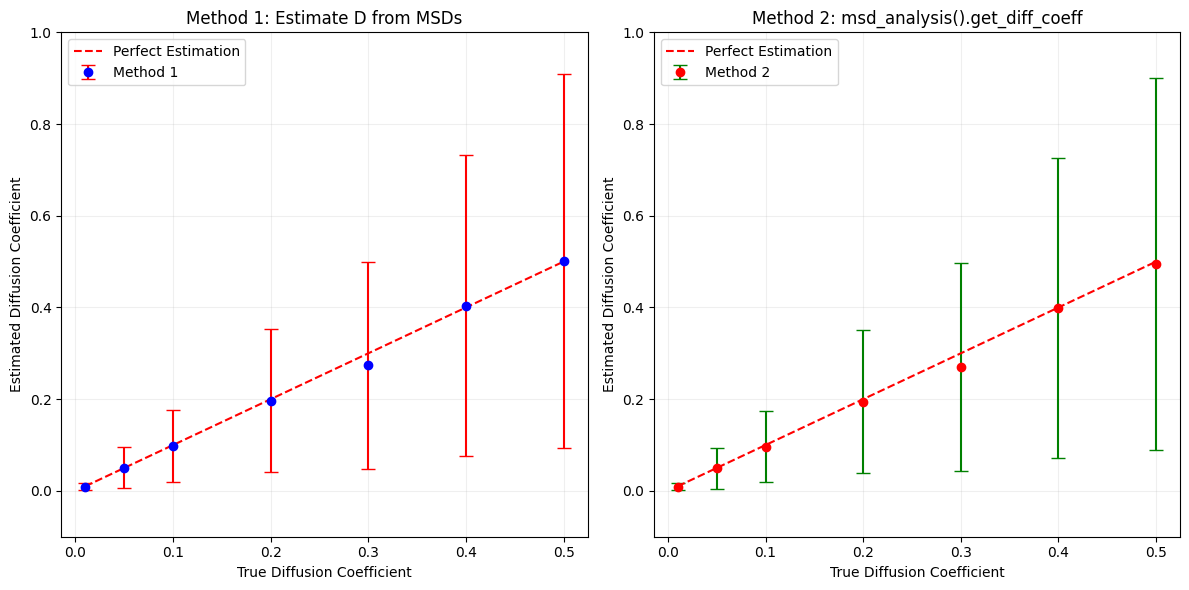

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_diffusion_coefficient_estimation_comparison():
    """
    Compare two methods of estimating diffusion coefficients:
    1. Estimating from Mean Square Displacements
    2. Using an alternative method (msd_analysis().get_diff_coeff)
    """
    # Parameters
    D_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    N = 500  # Number of particles
    T = 400  # Number of time steps
    nposFrame = 10
    t_lag_factor = 0.1

    time_range = np.arange(T * t_lag_factor)

    # Prepare plot
    plt.figure(figsize=(12, 6))
    
    # Lists to store results for error bar calculation
    true_Ds_means = []
    estimated_Ds_method1_means = []
    estimated_Ds_method1_stds = []
    estimated_Ds_method2_means = []
    estimated_Ds_method2_stds = []

    # Iterate through D values
    for D in D_values:
        # Generate trajectories
        trajs, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0.0], alphas=1)

        # Transpose trajectories
        trajsTrans = trajs.transpose(1, 0, 2)
        trajs_coarse = average_trajectories_frames(trajsTrans,nposFrame)

        # Calculate Mean Square Displacements
        msds = mean_square_displacements(trajsTrans)
        msds_coarse = mean_square_displacements(trajs_coarse)
        # Method 1: Estimate D from MSDs
        Ds_method1 = estimateDfromMSDs(msds, np.arange(T))

        # Method 2: Alternative method
        #Ds_method2 = msds_coarse[:,1] / (4 * nposFrame) * 1.5
        Ds_method2 = estimateDfromMSDs(msds_coarse, np.arange(T//nposFrame)) / nposFrame
        #Ds_method2 = estimateDfromMSDs(msds[:,:int(T*t_lag_factor)], time_range)
        #Ds_method2 = msd_analysis().get_diff_coeff(trajsTrans)

        # Store results for error bar calculation
        true_Ds_means.append(D)
        
        # Method 1 statistics
        estimated_Ds_method1_means.append(np.mean(Ds_method1))
        estimated_Ds_method1_stds.append(np.std(Ds_method1))
        
        # Method 2 statistics
        estimated_Ds_method2_means.append(np.mean(Ds_method2))
        estimated_Ds_method2_stds.append(np.std(Ds_method2))
        
        error = np.mean(np.abs(Ds_method1 - Ds_method2) / Ds_method1) * 100  # Convert to percentage
        print(f"For D: {D}: Error: {error:.2f}%")
    # Subplot for each method
    plt.subplot(1, 2, 1)
    # Method 1 Error bar plot
    plt.errorbar(true_Ds_means, estimated_Ds_method1_means, 
                 yerr=estimated_Ds_method1_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='red', 
                 markerfacecolor='blue', 
                 markeredgecolor='blue',
                 label='Method 1')
    
    # Perfect estimation line for Method 1
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 1: D from MSDs')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Method 2 subplot
    plt.subplot(1, 2, 2)
    plt.errorbar(true_Ds_means, estimated_Ds_method2_means, 
                 yerr=estimated_Ds_method2_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='green', 
                 markerfacecolor='red', 
                 markeredgecolor='red',
                 label='Method 2')
    
    # Perfect estimation line for Method 2
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 2: D from MSDs_coarse')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
plot_diffusion_coefficient_estimation_comparison()

For D: 0.01: Error: 2.69%
For D: 0.05: Error: 2.68%
For D: 0.1: Error: 2.75%
For D: 0.2: Error: 2.57%
For D: 0.3: Error: 2.78%
For D: 0.4: Error: 2.76%
For D: 0.5: Error: 2.69%


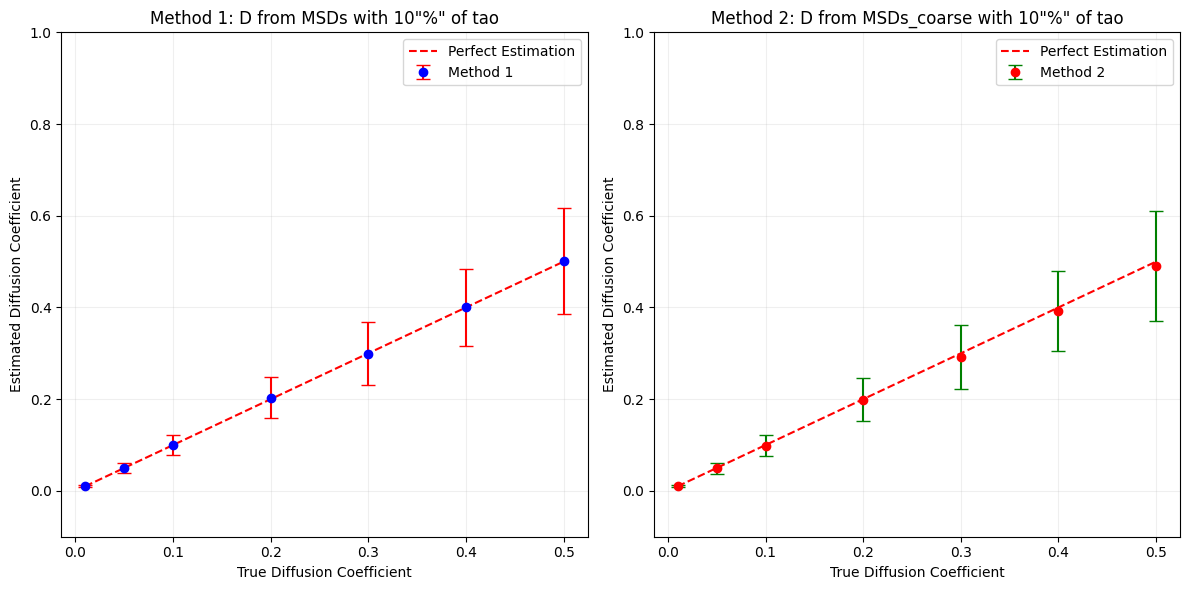

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_diffusion_coefficient_estimation_comparison():
    """
    Compare two methods of estimating diffusion coefficients:
    1. Estimating from Mean Square Displacements
    2. Using an alternative method (msd_analysis().get_diff_coeff)
    """
    # Parameters
    D_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    N = 500  # Number of particles
    T = 400  # Number of time steps
    nposFrame = 10
    t_lag_factor = 0.1

    time_range = np.arange(T * t_lag_factor)

    # Prepare plot
    plt.figure(figsize=(12, 6))
    
    # Lists to store results for error bar calculation
    true_Ds_means = []
    estimated_Ds_method1_means = []
    estimated_Ds_method1_stds = []
    estimated_Ds_method2_means = []
    estimated_Ds_method2_stds = []

    # Iterate through D values
    for D in D_values:
        # Generate trajectories
        trajs, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0.0], alphas=1)

        # Transpose trajectories
        trajsTrans = trajs.transpose(1, 0, 2)
        trajs_coarse = average_trajectories_frames(trajsTrans,nposFrame)

        # Calculate Mean Square Displacements
        msds = mean_square_displacements(trajsTrans)
        msds_coarse = mean_square_displacements(trajs_coarse)
        # Method 1: Estimate D from MSDs
        Ds_method1 = estimateDfromMSDs(msds[:,:int(T*t_lag_factor)], time_range)

        # Method 2: Alternative method
        #Ds_method2 = msds_coarse[:,1] / (4 * nposFrame) * 1.5

        # I dont know why this factor * 1.5 is there ?
        Ds_method2 = estimateDfromMSDs(msds_coarse[:,:int(T/nposFrame*t_lag_factor)], np.arange(T/nposFrame*t_lag_factor)) / nposFrame *1.14
        #Ds_method2 = estimateDfromMSDs(msds[:,:int(T*t_lag_factor)], time_range)
        #Ds_method2 = msd_analysis().get_diff_coeff(trajsTrans)

        # Store results for error bar calculation
        true_Ds_means.append(D)
        
        # Method 1 statistics
        estimated_Ds_method1_means.append(np.mean(Ds_method1))
        estimated_Ds_method1_stds.append(np.std(Ds_method1))
        
        # Method 2 statistics
        estimated_Ds_method2_means.append(np.mean(Ds_method2))
        estimated_Ds_method2_stds.append(np.std(Ds_method2))
        
        error = np.mean(np.abs(Ds_method1 - Ds_method2) / Ds_method1) * 100  # Convert to percentage
        print(f"For D: {D}: Error: {error:.2f}%")
    # Subplot for each method
    plt.subplot(1, 2, 1)
    # Method 1 Error bar plot
    plt.errorbar(true_Ds_means, estimated_Ds_method1_means, 
                 yerr=estimated_Ds_method1_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='red', 
                 markerfacecolor='blue', 
                 markeredgecolor='blue',
                 label='Method 1')
    
    # Perfect estimation line for Method 1
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 1: D from MSDs with 10"%" of tau')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Method 2 subplot
    plt.subplot(1, 2, 2)
    plt.errorbar(true_Ds_means, estimated_Ds_method2_means, 
                 yerr=estimated_Ds_method2_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='green', 
                 markerfacecolor='red', 
                 markeredgecolor='red',
                 label='Method 2')
    
    # Perfect estimation line for Method 2
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 2: D from MSDs_coarse with 10"%" of tau')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
plot_diffusion_coefficient_estimation_comparison()

For D: 0.01: Error: 11.57%
For D: 0.05: Error: 12.36%
For D: 0.1: Error: 13.81%
For D: 0.2: Error: 12.97%
For D: 0.3: Error: 12.10%
For D: 0.4: Error: 13.14%
For D: 0.5: Error: 12.47%


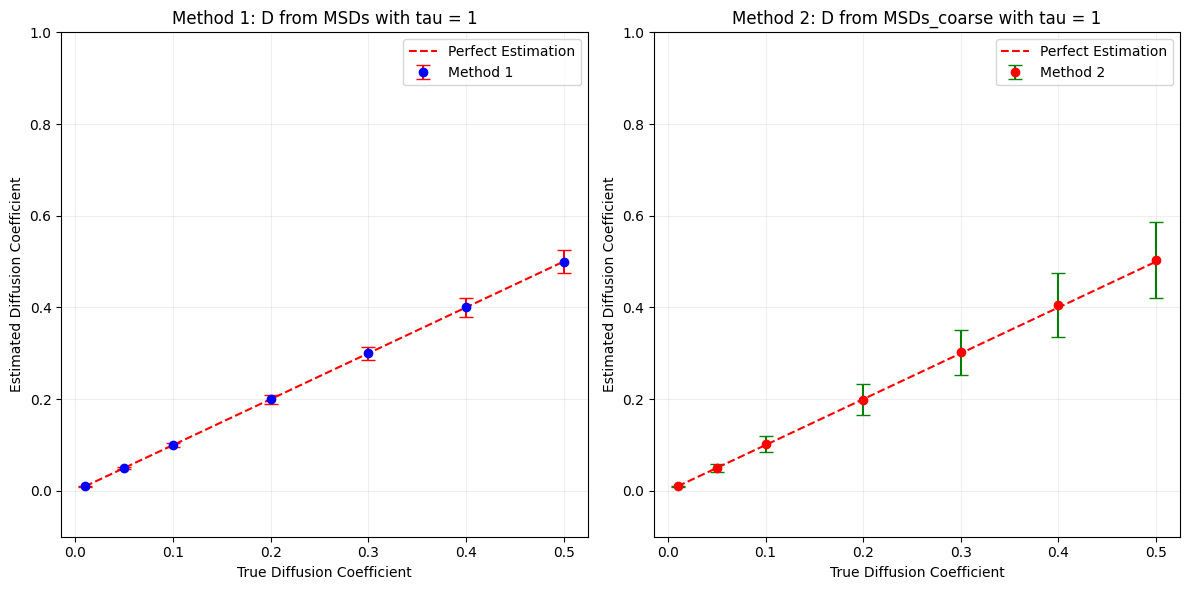

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_diffusion_coefficient_estimation_comparison():
    """
    Compare two methods of estimating diffusion coefficients:
    1. Estimating from Mean Square Displacements
    2. Using an alternative method (msd_analysis().get_diff_coeff)
    """
    # Parameters
    D_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    N = 500  # Number of particles
    T = 400  # Number of time steps
    nposFrame = 10
    t_lag_factor = 0.1

    time_range = np.arange(T * t_lag_factor)

    # Prepare plot
    plt.figure(figsize=(12, 6))
    
    # Lists to store results for error bar calculation
    true_Ds_means = []
    estimated_Ds_method1_means = []
    estimated_Ds_method1_stds = []
    estimated_Ds_method2_means = []
    estimated_Ds_method2_stds = []

    # Iterate through D values
    for D in D_values:
        # Generate trajectories
        trajs, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0.0], alphas=1)

        # Transpose trajectories
        trajsTrans = trajs.transpose(1, 0, 2)
        trajs_coarse = average_trajectories_frames(trajsTrans,nposFrame)

        # Calculate Mean Square Displacements
        msds = mean_square_displacements(trajsTrans)
        msds_coarse = mean_square_displacements(trajs_coarse)
        # Method 1: Estimate D from MSDs
        Ds_method1 = msds[:,1] / 4

        # Method 2: Alternative method
        #Ds_method2 = msds_coarse[:,1] / (4 * nposFrame) * 1.5

        # I dont know why this factor * 1.5 is there ?
        Ds_method2 = msds_coarse[:,1] / (4 * nposFrame) * 1.5
        #Ds_method2 = estimateDfromMSDs(msds[:,:int(T*t_lag_factor)], time_range)
        #Ds_method2 = msd_analysis().get_diff_coeff(trajsTrans)

        # Store results for error bar calculation
        true_Ds_means.append(D)
        
        # Method 1 statistics
        estimated_Ds_method1_means.append(np.mean(Ds_method1))
        estimated_Ds_method1_stds.append(np.std(Ds_method1))
        
        # Method 2 statistics
        estimated_Ds_method2_means.append(np.mean(Ds_method2))
        estimated_Ds_method2_stds.append(np.std(Ds_method2))
        
        error = np.mean(np.abs(Ds_method1 - Ds_method2) / Ds_method1) * 100  # Convert to percentage
        print(f"For D: {D}: Error: {error:.2f}%")
    # Subplot for each method
    plt.subplot(1, 2, 1)
    # Method 1 Error bar plot
    plt.errorbar(true_Ds_means, estimated_Ds_method1_means, 
                 yerr=estimated_Ds_method1_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='red', 
                 markerfacecolor='blue', 
                 markeredgecolor='blue',
                 label='Method 1')
    
    # Perfect estimation line for Method 1
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 1: D from MSDs with tau = 1')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Method 2 subplot
    plt.subplot(1, 2, 2)
    plt.errorbar(true_Ds_means, estimated_Ds_method2_means, 
                 yerr=estimated_Ds_method2_stds, 
                 fmt='o', 
                 capsize=5, 
                 ecolor='green', 
                 markerfacecolor='red', 
                 markeredgecolor='red',
                 label='Method 2')
    
    # Perfect estimation line for Method 2
    plt.plot(true_Ds_means, true_Ds_means, 'r--', label='Perfect Estimation')
    
    plt.xlabel('True Diffusion Coefficient')
    plt.ylabel('Estimated Diffusion Coefficient')
    plt.title('Method 2: D from MSDs_coarse with tau = 1')
    plt.ylim(-0.1, 1)  # Set y-axis range
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
plot_diffusion_coefficient_estimation_comparison()

In [4]:
trajs, labels = models_phenom().single_state(N, 
                                L = L,
                                T = T,
                                Ds = [D, 0.01], # Mean and variance
                                alphas = 0.5)
print(trajs.shape,labels.shape)
# Need to reshape generated trajectories because they are in format (T,N,dim), but we want them in (N,T,dim)
trajs = trajs.transpose(1,0,2)
labels = labels.transpose(1,0,2)
# Labels are now in format (N,T,3): for each particle T times the tuple (alpha, D, state)
print(f"Particle 0 [alpha, Gen_D, state]: {labels[0,0,:]}")
print(f"Particle 1 [alpha, Gen_D, state]: {labels[1,0,:]}")



(500, 500, 2) (500, 500, 3)
Particle 0 [alpha, Gen_D, state]: [0.5        0.09191772 2.        ]
Particle 1 [alpha, Gen_D, state]: [0.5        0.17778337 2.        ]


<Figure size 1000x600 with 0 Axes>

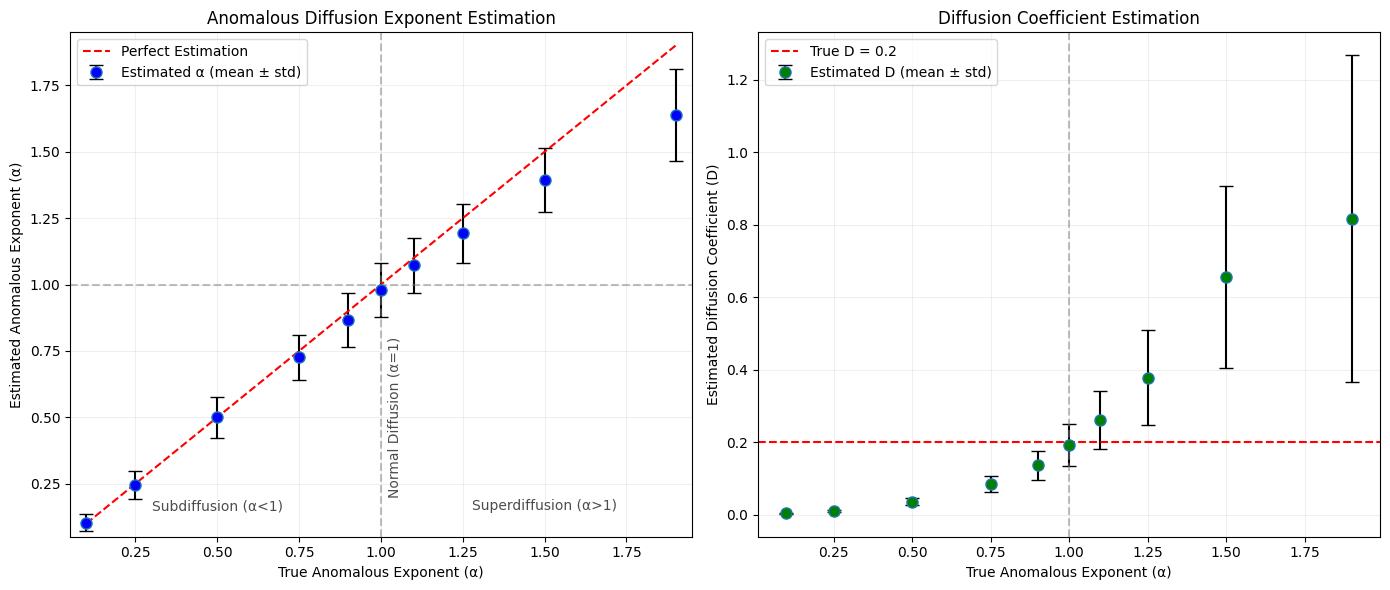

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_anomalous_exponent_estimation():
    # Parameters
    alpha_values = [0.1, 0.25, 0.5, 0.75, 0.9, 1, 1.1, 1.25, 1.5, 1.9]  # Range from 0.1 to 1.9
    N = 200  # Number of particles
    T = 200  # Number of time steps
    L =64   # Assuming L is defined in your original code
    true_D = 0.2  # Fixed diffusion coefficient
    
    # Prepare plot
    plt.figure(figsize=(10, 6))
   
    # Arrays to store mean and std of estimates for each alpha
    mean_alpha_estimates = []
    std_alpha_estimates = []
    mean_D_estimates = []
    std_D_estimates = []
    
    # Iterate through alpha values
    for alpha in alpha_values:
        # Generate trajectories with the specified alpha
        trajs, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=[D, 0], alphas=alpha)
        trajs = trajs.transpose(1,0,2)

        # Get the estimated exponents using your msd_analysis class
        estimated_exps = msd_analysis().get_exponent(trajs)
        # Get estimated diffusion coefficients
        # Assuming you have a method like this - adjust according to your actual implementation
        estimated_Ds = msd_analysis().get_diff_coeff(trajs)
        # Calculate mean and standard deviation of estimates
        msd_analysis().tamsd
        mean_alpha_estimates.append(np.mean(estimated_exps))
        std_alpha_estimates.append(np.std(estimated_exps))
        mean_D_estimates.append(np.mean(estimated_Ds))
        std_D_estimates.append(np.std(estimated_Ds))
    
    # Convert to numpy arrays
    mean_alpha_estimates = np.array(mean_alpha_estimates)
    std_alpha_estimates = np.array(std_alpha_estimates)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Anomalous exponent estimation
    ax1.errorbar(alpha_values, mean_alpha_estimates, yerr=std_alpha_estimates, 
               fmt='o', capsize=5, ecolor='black', markerfacecolor='blue', 
               markersize=8, label='Estimated α (mean ± std)')
    
    # Add perfect estimation line for alpha
    ax1.plot([0.1, 1.9], [0.1, 1.9], 'r--', label='Perfect Estimation')
    
    ax1.set_xlabel('True Anomalous Exponent (α)')
    ax1.set_ylabel('Estimated Anomalous Exponent (α)')
    ax1.set_title('Anomalous Diffusion Exponent Estimation')
    ax1.legend()
    ax1.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add reference lines for different diffusion regimes
    ax1.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
    ax1.text(1.02, 0.5, 'Normal Diffusion (α=1)', rotation=90, 
           verticalalignment='center', alpha=0.7)
    ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    
    # Add labels for different regimes
    ax1.text(0.5, 0.15, 'Subdiffusion (α<1)', ha='center', alpha=0.7)
    ax1.text(1.5, 0.15, 'Superdiffusion (α>1)', ha='center', alpha=0.7)
    
    ax1.set_xlim([0.05, 1.95])
    ax1.set_ylim([0.05, 1.95])
    
    # Plot 2: Diffusion coefficient estimation
    ax2.errorbar(alpha_values, mean_D_estimates, yerr=std_D_estimates, 
               fmt='o', capsize=5, ecolor='black', markerfacecolor='green', 
               markersize=8, label='Estimated D (mean ± std)')
    
    # Add true value reference line
    ax2.axhline(y=true_D, color='r', linestyle='--', 
              label=f'True D = {true_D}')
    
    ax2.set_xlabel('True Anomalous Exponent (α)')
    ax2.set_ylabel('Estimated Diffusion Coefficient (D)')
    ax2.set_title('Diffusion Coefficient Estimation')
    ax2.legend()
    ax2.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add reference line for normal diffusion
    ax2.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Run the analysis
plot_anomalous_exponent_estimation()